In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [2]:
# Set up parameters
data_dir = "dataset"
classes = ['clean', 'dirty']
image_size = 224

# Load and preprocess images
images = []
labels = []
for class_idx, class_name in enumerate(classes):
    class_path = os.path.join(data_dir, class_name)
    for file in os.listdir(class_path):
        try:
            img_path = os.path.join(class_path, file)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (image_size, image_size))
            images.append(img)
            labels.append(class_idx)
        except:
            continue

images = np.array(images) / 255.0
labels = np.array(labels)

print("Total Images:", len(images))
print("Class Distribution:", Counter(labels))

Total Images: 2444
Class Distribution: Counter({0: 1412, 1: 1032})


In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    images, labels, test_size=0.2, stratify=labels, random_state=42
)
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)
datagen.fit(X_train)

In [5]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

# Add classification head
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_test, y_test),
    epochs=12
)

Epoch 1/12
62/62 [==============================] - 46s 692ms/step - loss: 0.4222 - accuracy: 0.8128 - val_loss: 1.9674 - val_accuracy: 0.7423
Epoch 2/12
62/62 [==============================] - 40s 640ms/step - loss: 0.3050 - accuracy: 0.8655 - val_loss: 1.4759 - val_accuracy: 0.7689
Epoch 3/12
62/62 [==============================] - 37s 599ms/step - loss: 0.2563 - accuracy: 0.8864 - val_loss: 0.8968 - val_accuracy: 0.8282
Epoch 4/12
62/62 [==============================] - 38s 605ms/step - loss: 0.2427 - accuracy: 0.9028 - val_loss: 1.8365 - val_accuracy: 0.7996
Epoch 5/12
62/62 [==============================] - 38s 604ms/step - loss: 0.1708 - accuracy: 0.9325 - val_loss: 1.6980 - val_accuracy: 0.8446
Epoch 6/12
62/62 [==============================] - 38s 614ms/step - loss: 0.2085 - accuracy: 0.9258 - val_loss: 1.5979 - val_accuracy: 0.8221
Epoch 7/12
62/62 [==============================] - 38s 613ms/step - loss: 0.1803 - accuracy: 0.9355 - val_loss: 2.4042 - val_accuracy: 0.7444

16/16 [==============================] - 7s 373ms/step
              precision    recall  f1-score   support

       clean       0.82      0.92      0.87       283
       dirty       0.87      0.73      0.79       206

    accuracy                           0.84       489
   macro avg       0.85      0.83      0.83       489
weighted avg       0.84      0.84      0.84       489



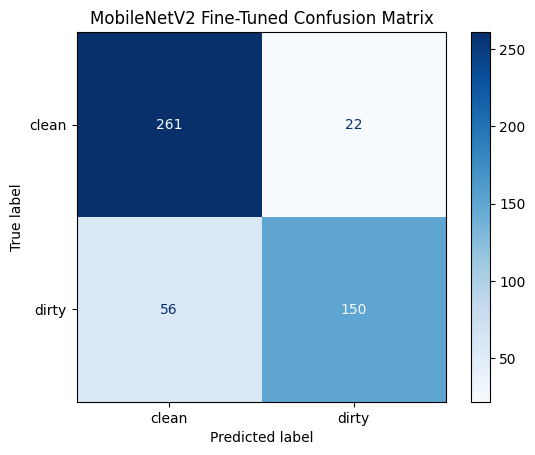

In [6]:
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred, target_names=classes))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred.ravel(), display_labels=classes, cmap='Blues')
plt.title("MobileNetV2 Fine-Tuned Confusion Matrix")
plt.show()

In [7]:
model.save("mobilenetv2_clean_dirty_classifier.h5")

['rf_model_clean_dirty.pkl']